In [62]:
import pandas as pd
import tqdm
import datetime

from langchain_core import outputs

df = pd.read_csv("./daily/stock_2024-12-26.csv")
cdf = pd.read_csv("stock_today.csv")
fdf = pd.read_csv("./daily/stock_fund_2024-12-26.csv")
cfdf = pd.read_csv("stock_fund_today.csv")
fdf = pd.concat([fdf,cfdf])
df = pd.concat([df,cdf])
df = df.merge(fdf)
df.dropna(inplace=True)
df.head()

,date,open,high,low,close,volume,amount,code,name,main_amount,main_percent
0,2024-11-18,27.99,28.25,27.15,27.32,3599179.0,99040517.0,sz301071,力量钻石,1881353.0,1.90
1,2024-11-19,27.35,28.06,27.17,28.05,2994500.0,82818869.0,sz301071,力量钻石,-8554834.0,-10.33
2,2024-11-20,27.92,28.31,27.80,28.20,2931460.0,82266534.0,sz301071,力量钻石,1389627.0,1.69
3,2024-11-21,28.18,28.33,27.50,27.82,3080719.0,86109404.0,sz301071,力量钻石,-11754611.0,-13.65
4,2024-11-22,27.80,27.95,26.66,26.66,3874720.0,105882085.0,sz301071,力量钻石,-2303917.0,-2.18


In [59]:
from sklearn.preprocessing import  KBinsDiscretizer
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

kbins = KBinsDiscretizer(n_bins=10,strategy='quantile',subsample=10000)
kbins.fit(df["volume"].dropna().values.reshape(-1,1))
vbin_edges = kbins.bin_edges_[0]
kbins = KBinsDiscretizer(n_bins=10,strategy='quantile',subsample=10000)
kbins.fit(df["main_amount"].dropna().values.reshape(-1,1))
mbin_edges = kbins.bin_edges_[0]


class ChangeVocab(object):

    def __init__(self,gap=20,buff=0.1):
        super().__init__()
        self.gap = gap
        self.buff = buff
        self.dim = 2*self.gap+1

    def __call__(self,v):
        if v<-self.gap or abs(v+self.gap)<self.buff:
            return 0
        elif v>self.gap or abs(v-self.gap)<self.buff:
            return self.gap+self.gap
        else:
            return int(round(v))+self.gap

class AmountVocab(object):
    def __init__(self,bin_edges):

        super().__init__()
        self.bin_edges = bin_edges
        self.dim = len(self.bin_edges)+1

    def __call__(self,v):
        for idx, e in enumerate(self.bin_edges):
            if v<e:
                return  idx
        return self.dim-1

class StdNormalize(object):
    def __init__(self,gap=20):
        super().__init__()
        self.gap = gap

    def __call__(self,v):
        if v<-self.gap:
            return -1
        elif v>self.gap:
            return 1
        else:
            return v/self.gap


class StockDataset(Dataset):
    def __init__(self, X,y = None):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return (torch.tensor(self.X.iloc[idx]["feature"], dtype=torch.float32),
                torch.tensor(self.y.iloc[idx],dtype=torch.float32))

def vocab_feature(r,p, pg):
    amount, price  = pg["amount"].mean(), pg["close"].mean()
    close = pvocab((r.close - p.close)*100/p.close)
    _open = pvocab((r.open - p.close)*100/p.close)
    high = pvocab((r.high - p.close)*100/p.close)
    low = pvocab((r.low - p.close)*100/p.close)
    volume = cvocab(np.log2(r.amount/amount))
    amount = avocab(r.amount)
    return [close,_open,high,low,volume,amount]

def nor_feature(r,p,pg):
    amount, price  = pg["amount"].mean(), pg["close"].mean()
    price_max, price_min = pg["close"].max(), pg["close"].min()
    amount_max, amount_min = pg["amount"].max(), pg["amount"].min()
    close = snor((r.close - p.close)*100/p.close)
    _open = snor((r.open - p.close)*100/p.close)
    high = snor((r.high - p.close)*100/p.close)
    low = snor((r.low - p.close)*100/p.close)
    plow =snor((r.low - price_min)*100/price)
    phigh =snor((r.high - price_max)*100/price)
    pclose =snor((r.close - price)*100/price)
    volume = vnor(np.log2(r.amount/amount))
    vhigh = vnor(np.log2(r.amount/amount_max))
    vlow = vnor(np.log2(r.amount/amount_max))
    amount = avocab(r.amount)/10
    mamount = avocab(r.main_amount)/10
    mpercent =mnor(r.main_percent)
    # [close,_open,high,low,volume,amount,plow,phigh, pclose,vhigh,vlow]

    return [close,_open,high,low,volume,amount,mamount, mpercent]

cdate = "2024-12-26"
avocab,mvocab = AmountVocab(vbin_edges),AmountVocab(mbin_edges)
cvocab,pvocab = ChangeVocab(gap=5),ChangeVocab(gap=10)
vnor, snor, mnor= StdNormalize(gap=5.0),StdNormalize(gap=10.0),StdNormalize(gap=25.0)
import numpy as np
codes, names, targets, features = [], [], [],[]
cnum = 10
for k,g in tqdm.tqdm(df.sort_values(by="date", ascending=False).groupby("code"),desc=f"processing date[{cdate}]"):
    cur = g[g.date==cdate]
    g = g[g.date<cdate]
    cg, pg = g[:cnum],g[cnum:]
    row = np.zeros((cnum,8),dtype=float)
    if cg.shape[0]==cnum and pg.shape[0]>0 and cur.shape[0]>0:
        cr,pr = cur.iloc[0],cg.iloc[0]
        codes.append(cr["code"])
        names.append(cr["name"])
        change = (cr.close-pr.close)*100/pr.close
        if change>10:
            change = 10
        elif change<-10:
            change = -10
        targets.append(change/10.0)
        for i in range(cg.shape[0]):
            r, p= g.iloc[i],g.iloc[i+1]
            row[i,:] = nor_feature(r,p,pg)
        features.append(row)
    # break
fdf = pd.DataFrame({"date":cdate, "code":codes,"name":names,"feature":features, "target": targets})
pdf =fdf.copy()
y = pdf.pop("target")
X_train,X_test,y_train,y_test = train_test_split(pdf,y,test_size=0.1)
trainset = StockDataset(X_train,y_train)
testset = StockDataset(X_test,y_test)
trainloader = DataLoader(trainset,batch_size=32,shuffle=True)
testloader = DataLoader(testset,batch_size=32,shuffle=False)
fdf.head()

processing date[2024-12-26]: 100%|██████████| 4410/4410 [00:56<00:00, 78.15it/s] 


,date,code,name,feature,target
0,2024-12-26,sh600000,浦发银行,"[[0.21717670286278268, 0.0, 0.2566633761105624...",-0.009662
1,2024-12-26,sh600004,白云机场,"[[0.010245901639344045, -0.030737704918032134,...",-0.071648
2,2024-12-26,sh600006,东风股份,"[[-0.23319615912208494, 0.0, 0.0, -0.370370370...",0.997191
3,2024-12-26,sh600007,中国国贸,"[[0.07780507780507687, 0.004095004095003281, 0...",-0.138155
4,2024-12-26,sh600008,首创环保,"[[0.029940119760479732, 0.029940119760479732, ...",-0.119403


In [60]:
from torch.nn import MSELoss
from torch.optim import Adam, SGD
from torch import nn
import torch
class DailyGRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(8, 64,num_layers=2, batch_first=True, bidirectional=False)
        self.linear = nn.Linear(2*64, 1)
        # self.init_weights()

    def forward(self,x):
        bs,length  = x.shape[0], x.shape[1]
        x = x.view((bs,length,-1))
        output, hn= self.rnn(x)
        y = hn.view((bs,-1))
        y = torch.relu(y)
        ouputs = self.linear(y)
        ouputs = torch.tanh(ouputs)
        return ouputs

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.zero_()


class DailyLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.pembedding = nn.Embedding(pvocab.dim, 64)
        self.cembedding = nn.Embedding(cvocab.dim, 64)
        self.aembedding = nn.Embedding(avocab.dim, 64)
        self.rnn = nn.GRU(6*64, 64,num_layers=2, batch_first=True, bidirectional=False)
        self.linear = nn.Linear(2*64, 1)
        # self.init_weights()
    def forward(self,x):
        bs,length  = x.shape[0], x.shape[1]
        pe = self.pembedding(x[:,:,:4])
        ce = self.cembedding(x[:,:,4:5])
        ae = self.aembedding(x[:,:,5:])
        # ae = ce+ae
        embedding = torch.cat((pe,ce,ae),dim=2)
        x = embedding.view((bs,length,-1))
        output, hn= self.rnn(x)
        y = hn.view((bs,-1))
        # print(hn.shape,y.shape)
        y = torch.relu(y)
        ouputs = self.linear(y)
        # print(ouputs.shape)
        ouputs = torch.tanh(ouputs)
        return ouputs
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.zero_()


model = DailyGRU()
# optimizer = Adam(model.parameters(),lr=0.001)
optimizer = SGD(model.parameters(),lr=0.001)
loss_fn = MSELoss()
for epoch in range(5):
    for i, batch in enumerate(trainloader):
        optimizer.zero_grad()
        X, y = batch
        output = model(X)
        loss = loss_fn(output,y.view(-1,1))
        loss.backward()
        if i % 20 == 0:
            print(f"Epoch:{epoch+1}, batch:{i}", loss.item())


Epoch:1, batch:0 0.02138970047235489
Epoch:1, batch:20 0.09061477333307266
Epoch:1, batch:40 0.04936011880636215
Epoch:1, batch:60 0.06723126769065857
Epoch:1, batch:80 0.03915470838546753
Epoch:1, batch:100 0.05196859687566757
Epoch:1, batch:120 0.030978254973888397
Epoch:2, batch:0 0.07343674451112747
Epoch:2, batch:20 0.06018947809934616
Epoch:2, batch:40 0.1439538300037384
Epoch:2, batch:60 0.04035067930817604
Epoch:2, batch:80 0.03753473982214928
Epoch:2, batch:100 0.11115176975727081
Epoch:2, batch:120 0.1228237897157669
Epoch:3, batch:0 0.10345152765512466
Epoch:3, batch:20 0.06495708227157593
Epoch:3, batch:40 0.07893729209899902
Epoch:3, batch:60 0.0835762470960617
Epoch:3, batch:80 0.04812691733241081
Epoch:3, batch:100 0.02282806485891342
Epoch:3, batch:120 0.0833878144621849
Epoch:4, batch:0 0.1366693526506424
Epoch:4, batch:20 0.06755844503641129
Epoch:4, batch:40 0.06480216234922409
Epoch:4, batch:60 0.09871530532836914
Epoch:4, batch:80 0.06929562240839005
Epoch:4, batch

In [61]:
model.eval()
lst, targets = [],[]
for i, batch in enumerate(testloader):
    X, y = batch
    targets.append(y)
    output = model(X)
    lst.append(output)
preds = torch.concat(lst)
targets = torch.concat(targets).view(-1,1)
loss_fn(preds,targets)

X_test["prediction"] = preds.detach().numpy()*10
X_test["target"] = targets.detach().numpy()*10
X_test.sort_values(by="prediction",ascending=False)[:100]

,date,code,name,feature,prediction,target
1968,2024-12-26,sz000882,华联股份,"[[-0.04761904761904871, 0.0, 0.333333333333332...",1.615878,5.263158
1603,2024-12-26,sh605268,王力安防,"[[-0.24234693877550958, 0.0, 0.025510204081633...",1.576490,10.000000
1767,2024-12-26,sz000546,金圆股份,"[[-0.335429769392032, -0.02096436058700165, 0....",1.572684,5.856833
718,2024-12-26,sh600981,汇鸿集团,"[[-0.2973977695167289, -0.03717472118959029, 0...",1.570100,1.149425
1027,2024-12-26,sh603082,北自科技,"[[-0.14987510407993315, 0.013877324451844895, ...",1.568625,2.986757
...,...,...,...,...,...,...
2163,2024-12-26,sz002026,山东威达,"[[-0.37827352085354077, 0.03879728419010586, 0...",1.340631,3.427419
793,2024-12-26,sh601158,重庆水务,"[[0.06048387096774244, 0.020161290322580218, 0...",1.340271,-1.803607
2207,2024-12-26,sz002073,软控股份,"[[-0.13301088270858458, -0.012091898428052947,...",1.339910,2.205882
1757,2024-12-26,sz000533,顺钠股份,"[[-0.34965034965035047, 0.046620046620045624, ...",1.339888,9.903381


MSE is: 7.81
The Pearson Correlation Coefficient is:0.04


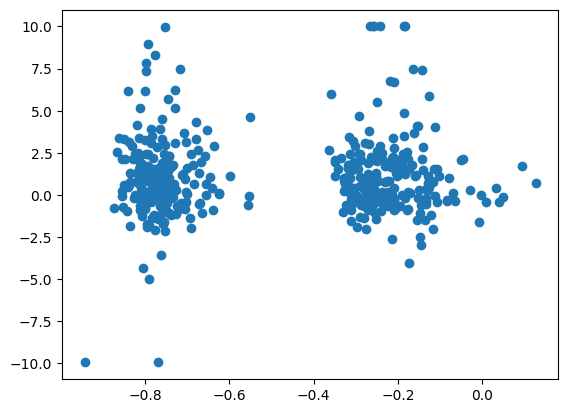

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
smse = mean_squared_error(X_test["prediction"], X_test["target"])
print(f"MSE is: {smse:.2f}")
pr = pearsonr(X_test["prediction"], X_test["target"])[0]
print(f"The Pearson Correlation Coefficient is:{pr:.2f}")
plt.scatter(X_test["prediction"], X_test["target"])
plt.show()
